# Final_PJT 

1. 데이터 summary & read
<br></br>
2. EDA
- 고객
  - 고객 state에 따른 분포도
  - 가격별 고객 state 
  - 배송비별 고객 state
  - city에 따른 고객 분포도

- 상품
  - 상관계수
  - 카테고리별 주문 수
  - 지역별 best 상품
  - 카테고리별 상품 수
  - 상품 크기 분포

- 주문
  - 주문별 결제 수단
  - 주문 상태'취소'
  - 일자(년도, 월, 요일, 시간)에 따른 주문건수
  - 지역(state, city)에 따른 주문건수

- 판매
  - state별 판매자 분포
  - 카테고리 판매량
  - seller_id별 상품판매
  - 상품판매에 따른 매출
  - 상품유통서비스세(tax) 와 review_score, price, freight_value, customer_state_code, seller_state_code, customer unique id

- 금액
  - 주문별 결제수단 확인
  - 날짜에 따른 가격변화
  
- 리뷰
  - 리뷰 평점 분포
  - WordCloud
  - review_score기준 데이터 분리 후 N-Gram 분석
  
- 배송
  - order_status를 활용한 분석
  - 배송날짜에 따른 유통과정 date 파악
  - 날짜에 따른 배송상태
  - 배송지역
<br></br>

---

## 1. 데이터 summary 및 read

출처 : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- 1) olist_customers_dataset
- 2) olist_geolocation_dataset
- 3) olist_order_items_dataset
- 4) olist_order_payments_dataset
- 5) olist_order_reviews_dataset
- 6) olist_orders_dataset
- 7) olist_products_dataset
- 8) olist_sellers_dataset
- 9) product_category_name_translation

### 1) 라이브러리 및 데이터 로드

In [ ]:
#!pip install folium
#!pip install mysql-connector-python
# !pip install pymysql

# !pip install sqlalchemy pymysql

In [278]:
# 라이브러리 로드
import mysql.connector
from sqlalchemy import create_engine, text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import rc
from plotly import tools
import plotly.offline as py
import folium
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

plt.rcParams['axes.unicode_minus'] = False
rc("font", family="Malgun Gothic")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [279]:
olist_customer = pd.read_csv('../dataset/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv('../dataset/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv('../dataset/olist_orders_dataset.csv')
olist_products = pd.read_csv('../dataset/olist_products_dataset.csv')
olist_sellers = pd.read_csv('../dataset/olist_sellers_dataset.csv')
olist_products_name_translation = pd.read_csv("../dataset/product_category_name_translation.csv")

In [280]:
# 각 데이터셋의 shape 확인
def shape_each_dataset(df, dataset_name="df"):
    print(f"{dataset_name} 의 데이터는 {df.shape[0]} dataset /  {df.shape[1]} 의 열로 구성")
    
    return df.shape[0], df.shape[1]

In [281]:
customer_r, customer_c = shape_each_dataset(olist_customer, "Olist Customer")
geolocation_r, geolocation_c = shape_each_dataset(olist_geolocation, "Olist Geolocation")
order_items_r, order_items_c = shape_each_dataset(olist_order_items, "Olist Order Items")
order_payments_r, order_payments_c = shape_each_dataset(olist_order_payments, "Olist Order Payments")
order_reviews_r, order_reviews_c = shape_each_dataset(olist_order_reviews, "Olist Order Reviews")
orders_r, orders_c = shape_each_dataset(olist_orders, "Olist Orders")
products_r, products_c = shape_each_dataset(olist_products, "Olist Products")
sellers_r, sellers_c = shape_each_dataset(olist_sellers, "Olist Sellers")

Olist Customer 의 데이터는 99441 dataset /  5 의 열로 구성
Olist Geolocation 의 데이터는 1000163 dataset /  5 의 열로 구성
Olist Order Items 의 데이터는 112650 dataset /  7 의 열로 구성
Olist Order Payments 의 데이터는 103886 dataset /  5 의 열로 구성
Olist Order Reviews 의 데이터는 99224 dataset /  7 의 열로 구성
Olist Orders 의 데이터는 99441 dataset /  8 의 열로 구성
Olist Products 의 데이터는 32951 dataset /  9 의 열로 구성
Olist Sellers 의 데이터는 3095 dataset /  4 의 열로 구성


AWS RDS Database 연결

In [ ]:
# MySQL 연결 정보
host = 'database-1.crtsqbi21zdv.ap-northeast-1.rds.amazonaws.com'
port = 3306
user = 'admin'
password = 'zerobase'
database = 'zerobase'

# 데이터베이스 연결
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')
conn=engine.connect()


# 데이터 
table_name = ['customer', 'geolocation', 'order_items','order_payments','order_reviews','orders','products','sellers','products_name_translation']
olist_customer.to_sql(name='customer', con=engine, if_exists='replace', index=False)

olist_order_items.to_sql(name='order_items', con=engine, if_exists='replace', index=False)
olist_order_payments.to_sql(name='order_payments', con=engine, if_exists='replace', index=False)
olist_order_reviews.to_sql(name='order_reviews', con=engine, if_exists='replace', index=False)
olist_orders.to_sql(name='orders', con=engine, if_exists='replace', index=False)
olist_products.to_sql(name='products', con=engine, if_exists='replace', index=False)
olist_sellers.to_sql(name='sellers', con=engine, if_exists='replace', index=False)
olist_products_name_translation.to_sql(name='products_name_translation', con=engine, if_exists='replace', index=False)
# olist_geolocation.to_sql(name='geolocation', con=engine, if_exists='replace', index=False)

In [283]:
# https://www.kaggle.com/code/gustavofelici/sql-mining-for-features-to-predict-order-score
# 쿼리문 작성하여 출력

def get_query(query):   
  return pd.read_sql_query(text(query), conn)



In [284]:
# 데이터 확인

query="""
show tables;
"""
    
get_query(query)

,Tables_in_zerobase
0,customer
1,order_items
2,order_payments
3,order_reviews
4,orders
5,products
6,products_name_translation
7,sellers
8,state_tax


In [181]:
datasets = [olist_customer, olist_geolocation, olist_order_items, 
            olist_order_payments,  olist_order_reviews, olist_orders, 
            olist_products, olist_sellers, olist_products_name_translation]

titles = ["customers", "geolocation", "items", "payments", "reviews",
         "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='tab20c')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_purchase_year, order_purchase_month, order_purchase_day, order_purchase_dayofweek, order_purchase_date, order_purchase_hour, order_purchase_year_month, average_order_purchase_timestamp",99441,16,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


---

## 2. EDA

### 1) 고객

In [8]:
# 브라질 STATE 간 유통세 
# - 상품/서비스 유통세는 주정부가 징수하는 부가가치세 
# - 과세율은 주 정부의 과세정첵에 따라 차이가 있음 
# - 주 간 이동 시 유통세는 하기 자료 확인 가능 

state_tax = pd.read_csv('../dataset/Brazil State ICMS.csv')
state_tax['tax(%)'] = state_tax['tax(ICMS)'] * 0.01
state_tax.head()

,customer_state_code,customer_state,seller_state_code,seller_state,tax(ICMS),tax(%)
0,0,AC,0,AC,17.0,0.17
1,0,AC,1,AL,12.0,0.12
2,0,AC,2,AM,12.0,0.12
3,0,AC,3,AP,12.0,0.12
4,0,AC,4,BA,12.0,0.12


In [305]:
query=""" 
SELECT *
FROM customer
INNER JOIN orders
    ON customer.customer_id = orders.customer_id
INNER JOIN order_reviews
    ON orders.order_id = order_reviews.order_id
INNER JOIN order_items
    ON orders.order_id = order_items.order_id
INNER JOIN products
    ON order_items.product_id = products.product_id
INNER JOIN order_payments
    ON orders.order_id = order_payments.order_id
INNER JOIN sellers
    ON order_items.seller_id = sellers.seller_id
"""
df_merge=get_query(query)


In [ ]:
df_merge= df_merge.merge(olist_products_name_translation, on='product_category_name')
df_merge = df_merge.merge(state_tax, on=['customer_state', 'seller_state'])
df_merge['tax(ICMS)'] = (df_merge['price'] + df_merge['freight_value']) * df_merge['tax(%)']
df_merge=df_merge.loc[:, ~df_merge.columns.duplicated(keep='first')]
df_merge.shape

상관계수

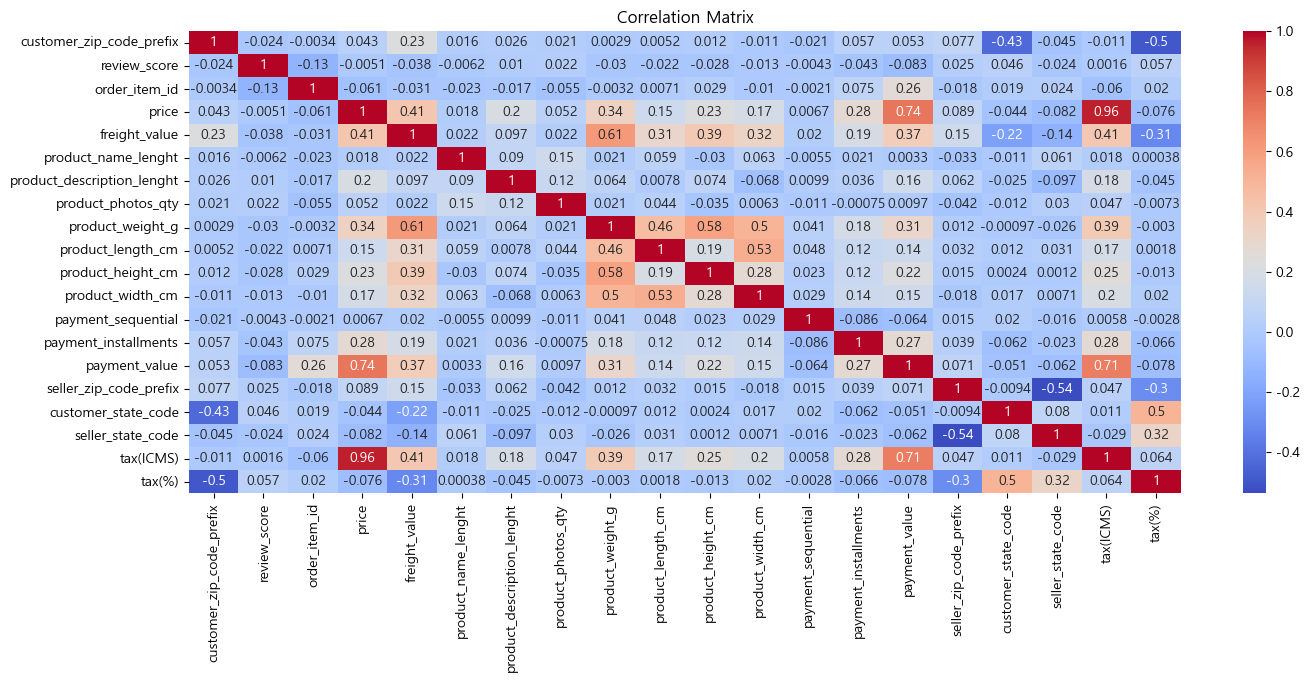

In [317]:
corr = df_merge.corr()

plt.figure(figsize=(16, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [318]:
time_columns= ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
               'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

df_merge[time_columns]=df_merge[time_columns].apply(pd.to_datetime)

In [319]:
customer_id_count = df_merge.groupby('customer_id').count()['customer_unique_id'].reset_index()
customer_id_count = customer_id_count.sort_values(by='customer_unique_id', ascending=False)
customer_id_count = customer_id_count.reset_index()
customer_id_count

,index,customer_id,customer_unique_id
0,14799,270c23a11d024a44c896d1894b261a83,63
1,7380,13aa59158da63ba0e93ec6ac2c07aacb,38
2,58458,9af2372a1e49340278e7c1ef8d749f34,29
3,55309,92cd3ec6e2d643d4ebd0e3d6238f69e2,26
4,37510,63b964e79dee32a3587651701a2b8dbf,24
...,...,...,...
96511,34395,5b7bd807fe0dcfe5208c642e07e268c9,1
96512,34394,5b7b7de303afbe0e48035449a3e86a5e,1
96513,34393,5b7b35a23a96b75f72bd1406d29a86c7,1
96514,34392,5b7ad66e4a9c19ef5ddceae95d05e46e,1


#### Customer Unique ID COUNT

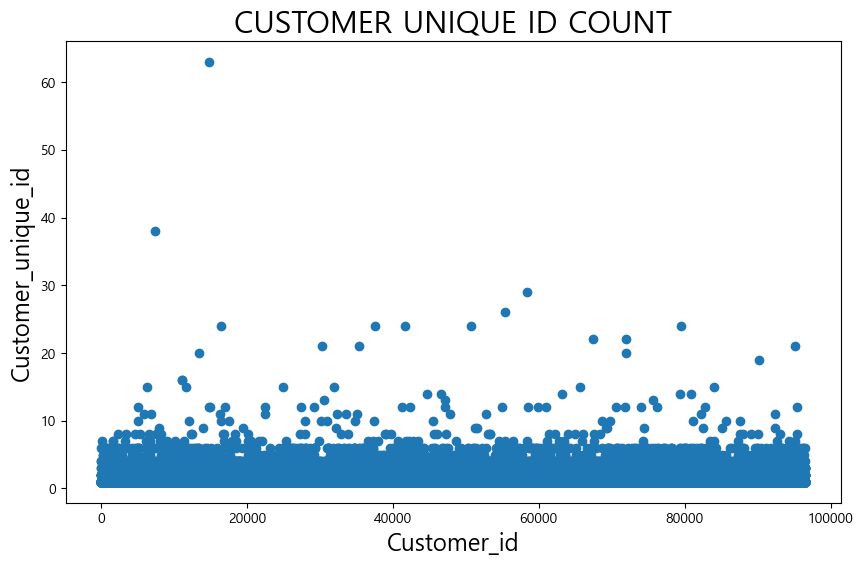

In [320]:
x = customer_id_count['index']
y = customer_id_count['customer_unique_id']

plt.figure(figsize=(10,6))
plt.title('CUSTOMER UNIQUE ID COUNT', fontsize=22)
s = plt.scatter(x,y)
plt.xlabel('Customer_id', fontsize=17)
plt.ylabel('Customer_unique_id', fontsize=17)
plt.show()

- customer unique ID 로 고객별 주문 횟수 확인 
- 한 고객이 10건 이상 구매한 경우 : 79 명 
- 한 고객이 10건 이하 구매한 경우 : 96437 명
- 한 고객이 1건만 구매한 경우 : 83927 명 

#### Customer's State Distribution

In [321]:
# clients number of each state
cli_num_state = df_merge.groupby(['customer_state']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id', ascending=False)
cli_num_state.head()

,customer_state,customer_unique_id
25,SP,48797
18,RJ,14987
10,MG,13429
22,RS,6413
17,PR,5879


In [322]:
# clients number of each city
cli_num_city = df_merge.groupby(['customer_city']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id', ascending=False)
cli_num_city.head()

,customer_city,customer_unique_id
3574,sao paulo,18267
3135,rio de janeiro,8022
451,belo horizonte,3196
556,brasilia,2434
1139,curitiba,1790


(0.0, 53676.700000000004)

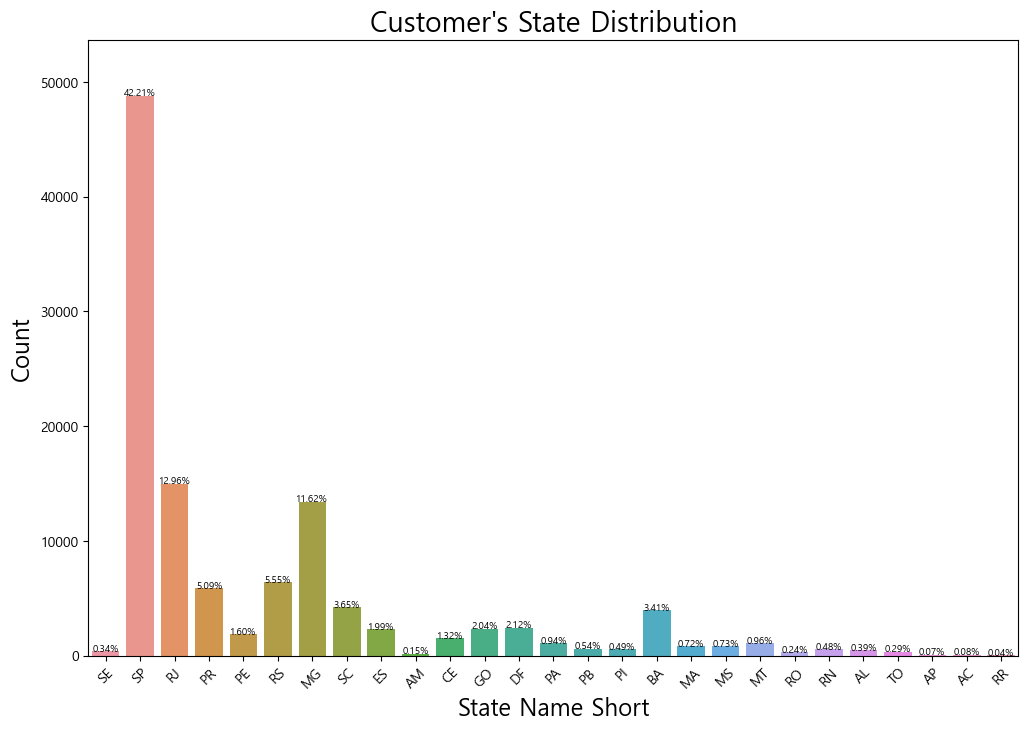

In [323]:
plt.figure(figsize=(12,8))
plt.title('CUSTOMER State Distributions', fontsize=22)
g = sns.countplot(x='customer_state', data=df_merge, orient='h')
g.set_title("Customer's State Distribution", fontsize=20)
g.set_xlabel("State Name Short", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df_merge)*100),
            ha="center", fontsize=7) 
g.set_ylim(0, max(sizes) * 1.1)

#### Customer's State by Price

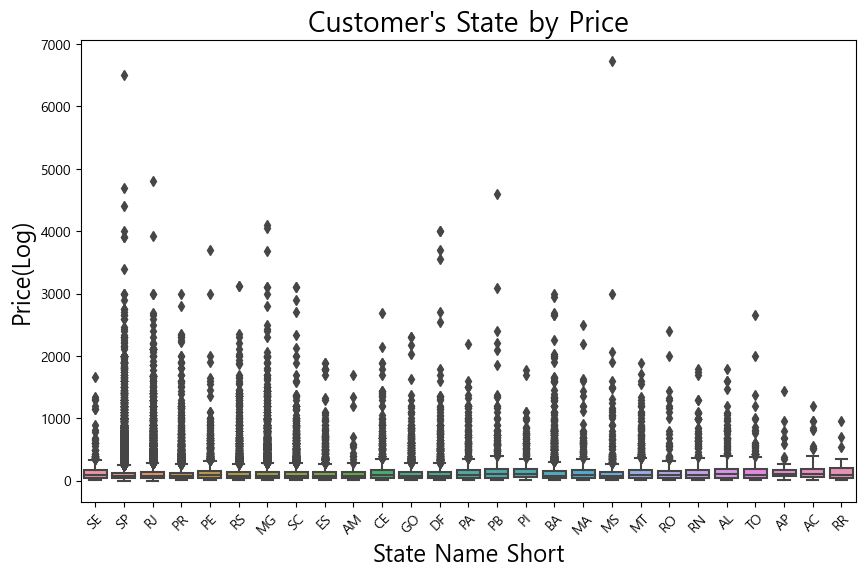

In [324]:
df_merge['price_log'] = np.log(df_merge['price'] + 1.5)
plt.figure(figsize=(10,6))

g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_merge)
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State Name Short", fontsize=17)
g2.set_ylabel("Price(Log)", fontsize=17)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
plt.show();

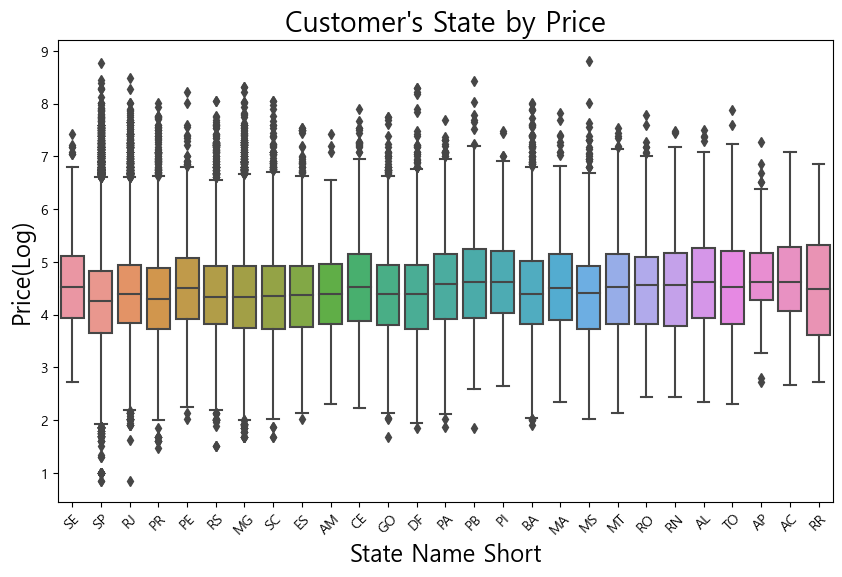

In [325]:
df_merge['price_log'] = np.log(df_merge['price'] + 1.5)
plt.figure(figsize=(10,6))

g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_merge[df_merge['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State Name Short", fontsize=17)
g2.set_ylabel("Price(Log)", fontsize=17)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
plt.show();

#### Customer's State by Freight Value

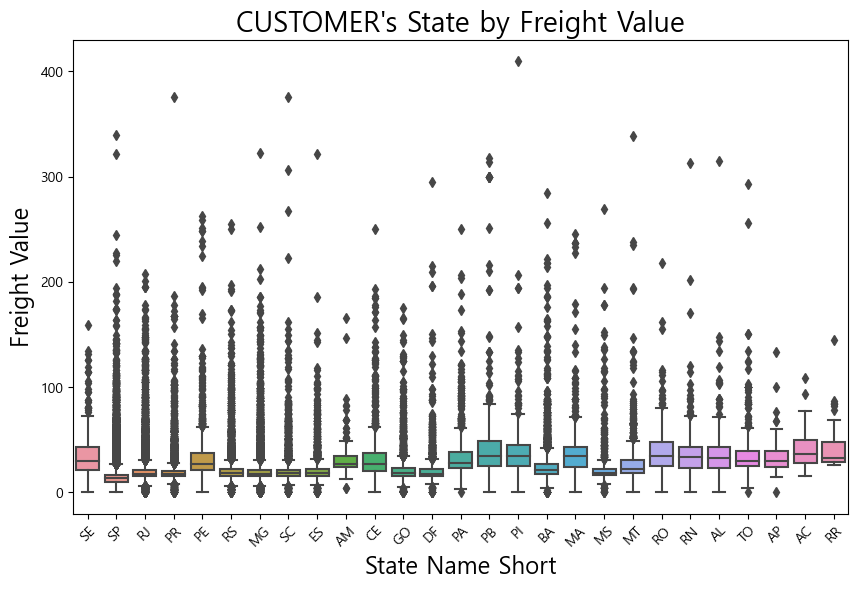

In [326]:
plt.figure(figsize=(10,6))
g3 = sns.boxplot(x='customer_state', y='freight_value', 
                 data=df_merge)
g3.set_title("CUSTOMER's State by Freight Value", fontsize=20)
g3.set_xlabel("State Name Short", fontsize=17)
g3.set_ylabel("Freight Value", fontsize=17)
g3.set_xticklabels(g3.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

#### Customer's State

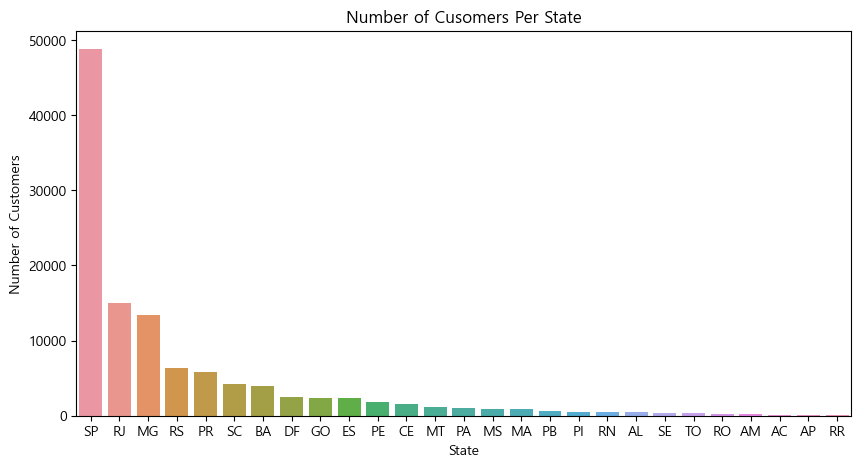

In [327]:
state_df = df_merge.groupby('customer_state').count()['customer_id'].reset_index()
city_df = df_merge.groupby('customer_city').count()['customer_id'].reset_index()

plt.figure(figsize=(10,5))

# state 별 고객 분포도 

sns.barplot(data = state_df.sort_values('customer_id', ascending = False),x = 'customer_state', y = 'customer_id')
plt.title('Number of Cusomers Per State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.show();

#### city 별 고객 분포도 

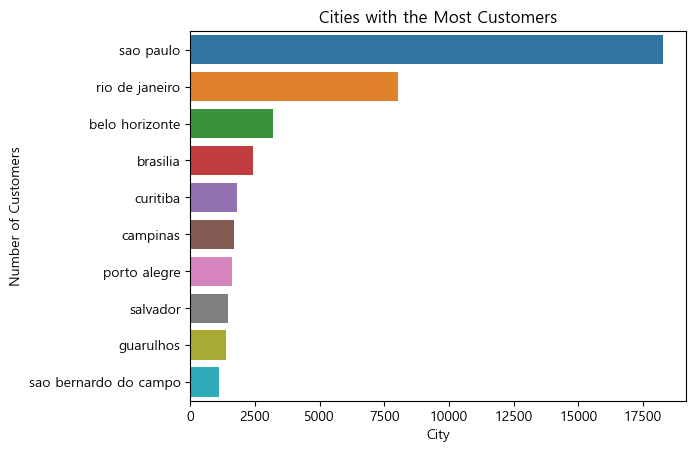

In [328]:
sns.barplot(data = city_df.sort_values('customer_id', ascending = False).nlargest(10, 'customer_id'), x = 'customer_id', y='customer_city')
plt.title('Cities with the Most Customers')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.show();

- 대부분의 고객들의 state, city는 Sao paulo, rio de janeiro에 분포되고 있다. 

---